## Initializing the experiment

First, create the 'common' part of the dyngen simulations as follows. This will ensure that the gene regulatory network part of the simulation is exactly the same.

In [29]:
library(dyno)
library(purrr)
library(scran)
library(scater)
library(slurmR)
library(dyngen)
library(igraph)
library(parallel)
library(dynutils)
library(tidyverse)
library(assertthat)
library(data.table)
library(matrixStats)
library(SingleCellExperiment)
source("../scripts/backbone_cellpop.R")

create_ko_script = "/scratcha/fmlab/baker02/tidyscreen/scripts/create_ko_models.R"
perturb_dir = "/scratcha/fmlab/baker02/tidyscreen/data/dev_generating_perturbed_models"

set.seed(1)
options(repr.plot.width=12, repr.plot.height=12)

# How to Simulate a gRNA Perturbation

In the following section of code I am looking to develop methods to simulate individual gRNAs perturbations of genes. There are 4 key features of a gRNA that can be controlled:
   
       1) Whether the Gene was Perturbed a given cell
       2) The Gene Targeted, 
       3) On-Target Activity
       4) Off-Target Activity. 

## Utility Functions 

Below is the code i am developing to generate perturbed models from dyngen.

### Functions Related to Creating Perturbed Models

In [142]:
run_perturbation_experiment = function(common_model, target_genes, output_dir='perturb_models', data_dir='../data', 
                                       off_target_genes=c(), num_of_grnas=1, off_target_vec=c(0), on_target=c(1), 
                                       random_on_target=FALSE, num_of_sims=100, ctrl_label="CTRL", experiment_type='KO', slurm=FALSE){
    
    target_genes = c(ctrl_label, target_genes)
    output_dir = create_output_directory(data_dir, output_dir)
    
    # creating perturbation models, generate cells for each model, generate experiment, and update cell metadata
    perturb_models = create_perturbation_models(common_model, target_genes, off_target_genes, num_of_grnas, off_target_vec,
                                                on_target, random_on_target, num_of_sims, ctrl_label, experiment_type, output_dir)
    
    perturb_models = generate_models_cells(perturb_models, slurm)
    return (perturb_models)
}

create_output_directory = function(data_dir, output_dir){
    # creating an output directory filepath and making sure the directory exists
    output_dir = file.path(data_dir, output_dir)
    
    if (!dir.exists(output_dir)){
        dir.create(output_dir, recursive = TRUE)
    }
    
    return (output_dir)
}

create_perturbation_models = function(common_model, target_genes, off_target_genes, num_of_grnas, off_target_vec,
                                      on_target, random_on_target, num_of_sims, ctrl_label, experiment_type, output_dir) {
    # creating individual instances of both CTRL and target gene gRNA KO models
    models = list()

    for (target_gene in target_genes) {
        if (target_gene == 'CTRL') {
            models[[target_gene]]$model = common_model
            models[[target_gene]]$model$numbers$num_cells = models[[target_gene]]$numbers$num_cells * num_of_grnas

        } else {
            # create KO models for each Target Gene gRNAs
            genes_grnas = create_gene_grnas(target_gene, off_target_genes, num_of_grnas, off_target_vec,
                                            on_target, random_on_target, experiment_type)
            models[[target_gene]]$model = create_grna_models(common_model, genes_grnas, num_of_sims)
        }
        
        models[[target_gene]]$output_dir = output_dir
    }
    
    return (models)
}

generate_models_cells = function(perturb_models, slurm) {
    # run generate cells for all models in the experiment. Depending on user input we can run the simulations 
    # on a slurm cluster or locally.
    if (slurm == TRUE) {
        perturb_models = run_slurm(perturb_models)
    } else {
        perturb_models = run_locally(perturbed_models)
    }
    
    return (perturb_models)
}

create_gene_grnas = function(target_gene, off_target_genes, num_of_grnas, off_target_vec, on_target, random_on_target, experiment_type) {
    target_grnas = data.frame()
    
    for (grna_i in 1:num_of_grnas) {
        not_target_genes = off_target_genes[off_target_genes != target_gene]
        
        # for each grna generate the off and on target activity
        grna_name = paste0(target_gene, "_grna_", grna_i)
        off_target_meta = off_target_effect(off_target_vec, not_target_genes)
        perturb_genes = c(target_gene, off_target_meta$off_target_genes)
        on_target_meta = on_target_effect(grna_name, perturb_genes, on_target, random_on_target, off_target_meta$num_of_genes, experiment_type)
        
        # creating the gRNA Metadata data frame
        grna = data.frame(model_name = on_target_meta$model_names,
                          experiment_type = experiment_type,
                          grna_name = grna_name,
                          target_gene = target_gene,
                          perturbed_genes = paste(perturb_genes, collapse = ','), 
                          num_genes = off_target_meta$num_of_genes,
                          num_off_targets = off_target_meta$num_off_targets,
                          sample_percentage = on_target_meta$sample_percentage)
        
        # adding elements that are meant to be stored as lists into the gRNA data frame
        grna = grna %>% rowwise %>%
                 mutate(on_target_effects = on_target_meta$on_target, 
                        perturbed_gene_list = strsplit(perturbed_genes, ','),
                        kd_multiplier = list(as.numeric(on_target_meta$kd_multiplier[model_name, ])))
        
        target_grnas = rbind(target_grnas, grna)
    }
    
    return (target_grnas)
}

create_grna_models = function(common_model, gene_grnas, num_of_sims) {
    # generating individual ko models for a given target genes grna
    grna_models = list()
    grna_names = gene_grnas$grna_name

    for (grna_i in 1:nrow(gene_grnas)) {
        model_grna = common_model
        
        grna = gene_grnas[grna_i, ]
        grna_name = grna_names[grna_i]
        grna = duplicate_grnas(grna, num_of_sims)

        expr_params = simulation_type_knockdown(num_simulations = num_of_sims,
                                                num_genes = grna$num_genes,
                                                genes = grna$perturbed_gene_list,
                                                multiplier = grna$kd_multiplier)

        model_grna$simulation_params$experiment_params = expr_params
        grna_models[[grna_name]] = model_grna
    }
    
    return (grna_models)
}

duplicate_grnas = function(dat, sim_count_per_grnas){
    grnas = data.frame()
    
    for (i in 1:sim_count_per_grnas){
        grnas = rbind(grnas, dat)
    }
    
    return (grnas)
}

off_target_effect = function(off_target_vec, genes){
    #select the number off target genes through random sampling
    
    if (length(off_target_vec) < 1){
        num_off_targets = sample(off_target_vec, 1, replace=TRUE)
    } else {
        num_off_targets = off_target_vec[1]
    }
    
    # randomly select the genes that are going to be off targets
    num_of_genes = num_off_targets + 1
    off_target_genes = sample(genes, num_off_targets)
    return (list(num_off_targets=num_off_targets, off_target_genes=off_target_genes, num_of_genes=num_of_genes))
}


on_target_effect = function(grna_name, perturb_genes, on_target, random_on_target, num_genes, experiment_type) {
    
    # generate randomized on target if specified
    if (random_on_target == TRUE){
        on_target = runif(num_genes)
    } 
    
    # generate KD Multiplier matrix. If KO Matrix will be Multiplier rows if interference matrix will have 1 row.
    if (experiment_type == 'KO'){
        kd_multiplier = ko_on_target_effect(perturb_genes)
        sample_perc = calc_sample_percentages(on_target, kd_multiplier)
        names_for_model = create_model_names(grna_name, kd_multiplier)
    } else {
        kd_multiplier = interference_on_target_effect(on_target, random_kd_multiplier, num_genes)
        names_for_model = grna_name
        sample_perc = 1
    }
    
    # return the On Target information and KD Multiplier Matrix
    rownames(kd_multiplier) = names_for_model
    return (list(on_target=list(on_target), kd_multiplier=kd_multiplier, model_names=names_for_model, sample_percentage=sample_perc))
}

ko_on_target_effect = function(perturbed_genes) {
    # generating all of the potiential combinations of KO effects for a given gRNA
    combinations = list()

    for (gene in perturbed_genes){
        combinations[[gene]] = 0:1
    }
    
    kd_multiplier = combinations %>% as.data.frame %>% expand.grid()
    return (kd_multiplier)
}

interference_on_target_effect = function(kd_multiplier, random_kd_multiplier, num_genes) {
    # randomly samples the on target activity of a gRNA for both it's target genes and off-target genes
    kd_multiplier = 1 - kd_multiplier
    on_target = t(as.data.frame(rep(kd_multiplier, num_genes / length(kd_multiplier))))
    return (on_target)
}

calc_sample_percentages = function(on_target, kd_multiplier){
    # calculate the percentage of cells that should be sampled from 
    # a given model.
    probs_mat = data.frame()
    
    for (i_row in 1:nrow(kd_multiplier)) {
        row = kd_multiplier[i_row, ]
        
        for (i_col in 1:ncol(kd_multiplier)) { 
            gene_on_target = on_target[i_col]
            value = kd_multiplier[i_row, i_col]

            if (value == 1) {
                # probability of grna edit
                row[i_col] = gene_on_target
            } else {
                # probability of no edit
                row[i_col] = 1 - gene_on_target
            }
        }

        probs_mat = rbind(probs_mat, row)
    }

    sample_percentages = rowProds(as.matrix(probs_mat))
    return (sample_percentages)
}

create_model_names = function(grna_name, kd_multiplier) {
    model_names = c()

    for (i in 1:nrow(kd_multiplier)) {
        model_name = grna_name

        for (col in colnames(kd_multiplier)) {
            value = kd_multiplier[i, col]
            
            if (value == 1) {
                model_name = paste0(model_name, "_", col, "PRT")
            } else {
                model_name = paste0(model_name, "_", col, "NT")
            }
        }
        
        model_names = c(model_names, model_name)
    }
    
    return (model_names)
}

############################################### Code to run dyngen locally or with slurm ###############################################

run_slurm = function(perturb_models) {
    # submitting a job array to slurm to parallel process
    # setting dyngen job array job count, sbatch options and submitting array to slurm
    max_job_count = 200
    perturb_model_count = length(perturb_models)
    
    # setting the number of jobs to be submitted to slurm
    if (perturb_model_count > max_job_count) {
        num_of_models = max_job_count
    } else {
        num_of_models = perturb_model_count
    }
    
    dyngen_job_opts = list(time='1-00:00:00', mem="6G")
    perturb_models = Slurm_lapply(perturb_models, generate_cells, mc.cores = 1,
                                  njobs = num_of_models, sbatch_opt = dyngen_job_opts, plan = "collect")
    
    return  (perturb_models)
}

run_locally = function(perturb_models) {
    # code to generate cells of dyngen models locally
    for (model_name in names(perturb_models)) {
        message(paste0("Generating Cells for ", model_name, "..."))
        
        # select model and generate cells for said model
        model = perturb_models[[model_name]]
        model = generate_cells(model)

        # reassign model with the generated cells
        perturb_models[[model_name]] = model
    }
    
    return (perturb_models)
}

############################################### Code to Generate Cells and Experiment using Dyngen ###############################################

generate_cells = function(model_list) {
    model = model_list$model
    output_dir = model_list$output_dir
    
    # generate cells and experiments
    model = model %>% 
                generate_cells() %>%
                generate_experiment()
    
    # update cell metadata from dyngen 
    model = update_cell_metadata(model)
    
    # convert dyngen model to sce
    sce = convert_dyngen_to_sce(model)
    
    # save dyngen and sce objects
    output = save_output(model, sce, output_dir)
    return (output)
}

update_cell_metadata = function(model) {
    # update cell metadata with the gRNA/Perturbation Data
    cell_meta = model$experiment$cell_info
    kd_multiplier = model$simulations$kd_multiplier

    cell_meta = cell_meta %>%
                    left_join(kd_multiplier, by='simulation_i') %>%
                    mutate(grna_name = model,
                           cell_population = str_extract(model, ".+?(?=_)"), 
                           target_gene = gsub('*|_gRNA_[1-9]', '', model),
                           multiplier = ifelse(is.na(multiplier), 1, multiplier))

    model$experiment$cell_info = cell_meta
    return (model)
}

convert_dyngen_to_sce = function(model){
    # take the provided dyngen model (must have all perturbations merged) and convert it to a SCE object
    sce = as_sce(model)
    sce = update_sce_coldata(sce, model)
    
    return (sce)
}

save_output = function(model, sce, output_dir) {
    dyngen_filename = paste0('dyngen_model_', dataset_count, '.Rds')
    sce_filename = paste0('sce_of_dyngen_model_', dataset_count, '.Rds')

    sce_filepath = file.path(data_dir, sce_filename)
    dyngen_filepath = file.path(data_dir, dyngen_filename)

    saveRDS(sce, sce_filepath)
    saveRDS(perturb_expr, dyngen_filepath)
    
    return (list(dyngen_fp=dyngen_filepath, sce_fp=sce_filepath))
}

update_sce_coldata = function(sce, model, cols_of_interest=c('cell_id', 'target_gene', 'grna_name', 'cell_population')) {
    # mergining metadata from dyngen into sce object. That were previously left out such as target_gene, grna_name, and cells pop.
    
    cell_info = model$experiment$cell_info
    colData(sce)$cell_id = rownames(colData(sce))
    
    temp = colData(sce) %>%
            as.data.frame %>%    
            left_join(cell_info[, cols_of_interest], by='cell_id')

    colData(sce) = cbind(colData(sce), temp)
    return(sce)
}

In [143]:
# need start checking the paramters in order to check that it makes sense
# genes_grnas = create_gene_grnas('target1', c('test1', 'test2', 'test3', 'test4'), 2, c(2), c(1, .5, .3), TRUE, "KO")
# target_gene, off_target_genes, num_of_grnas, off_target_vec, on_target, random_on_target, experiment_type

# look at the grna metadata
# genes_grnas

## Testing CRISPR gRNA Generating Code

In [144]:
num_cells = 1000
cellpop_backbone = backbone_single_cell_population()

config = initialise_model(
    backbone = cellpop_backbone,
    num_cells = num_cells,
    num_targets = 500,
    num_hks = 500,
    gold_standard_params = gold_standard_default(
      census_interval = 1,
      tau = 100 / 3600),
    simulation_params = simulation_default(
      census_interval = 10,
      ssa_algorithm = ssa_etl(tau = 300 / 3600),
      experiment_params = simulation_type_wild_type(
        num_simulations = 100
    )))

config$num_cores = 5

In [145]:
# creating transcription factor network and generate kinetics
model_common = config %>%
                  generate_tf_network() %>%
                  generate_feature_network() %>% 
                  generate_kinetics() %>%
                  generate_gold_standard()

Generating TF network
Sampling feature network from real network
Generating kinetics for 1023 features
Generating formulae
Generating gold standard mod changes
Precompiling reactions for gold standard
Running gold simulations
  |==================================================| 100% elapsed=00s, remaining~00s


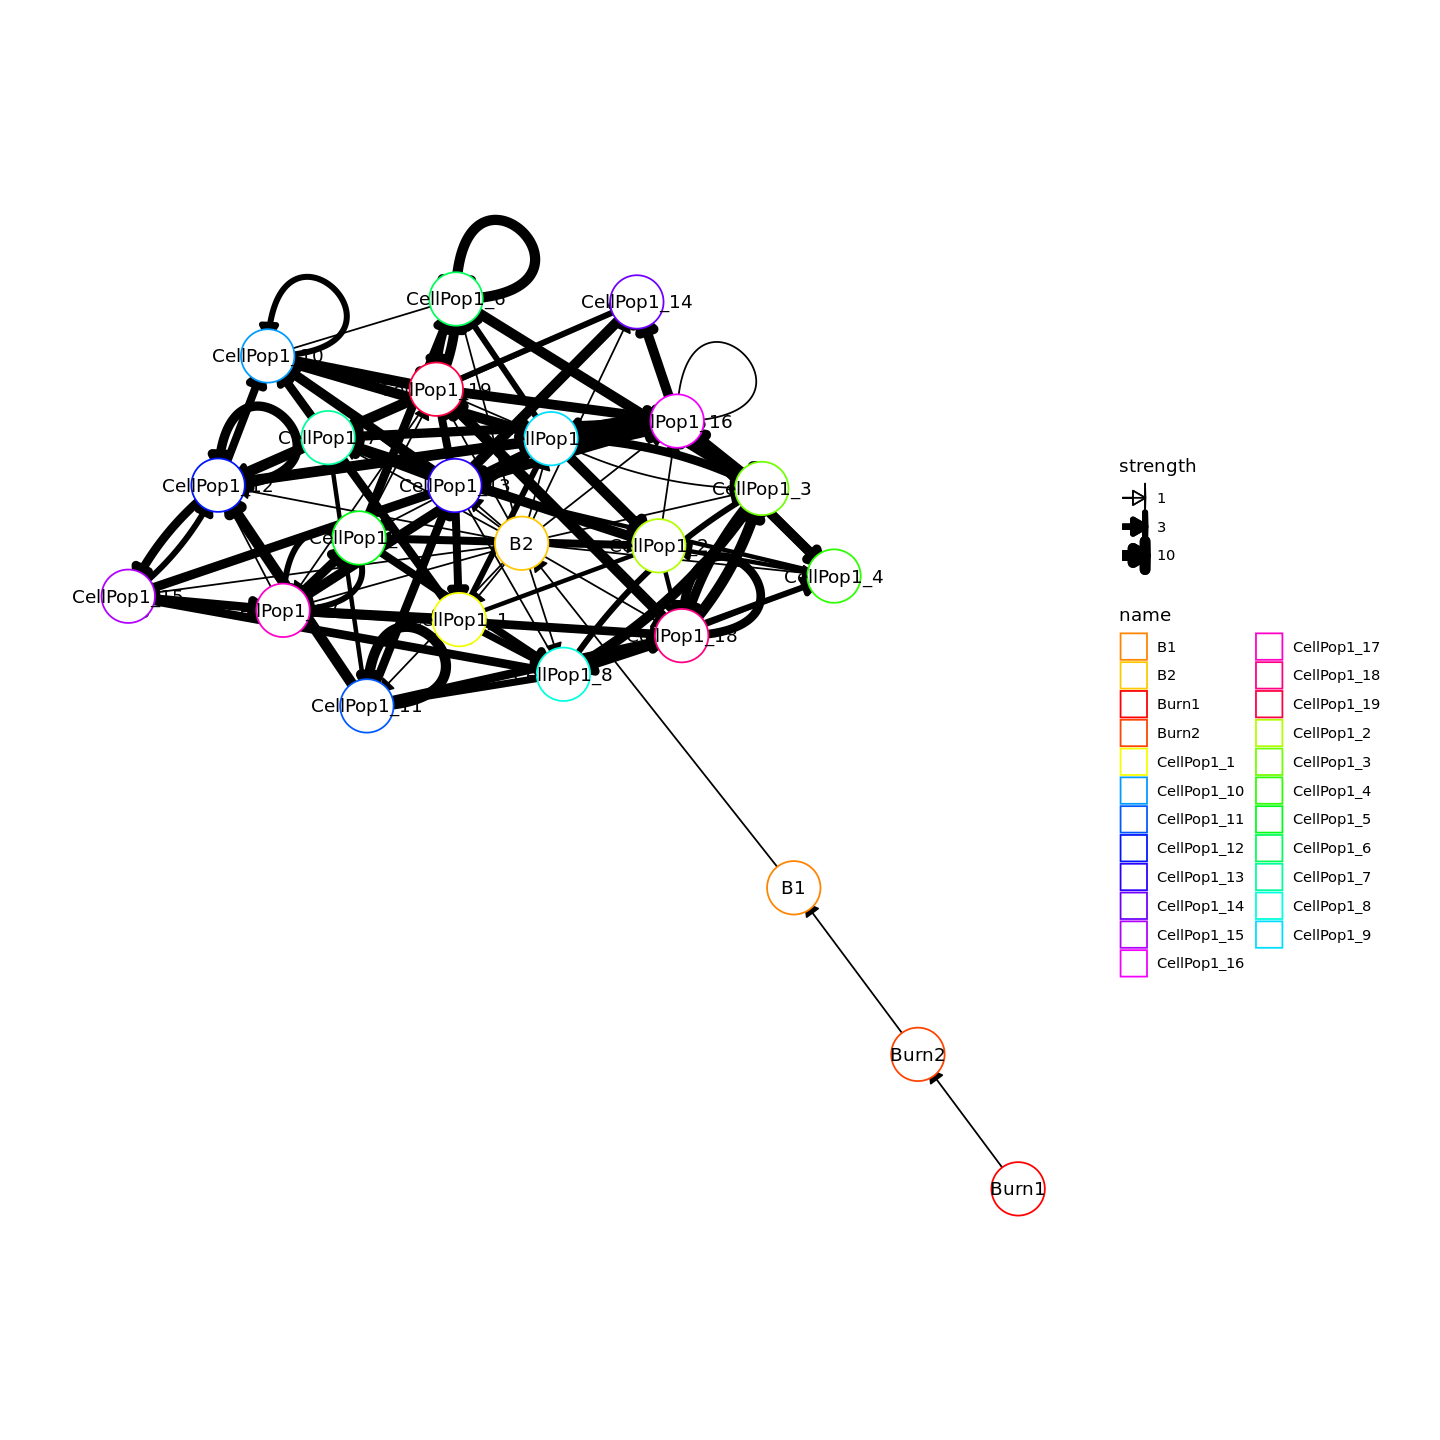

In [146]:
plot_backbone_modulenet(model_common)

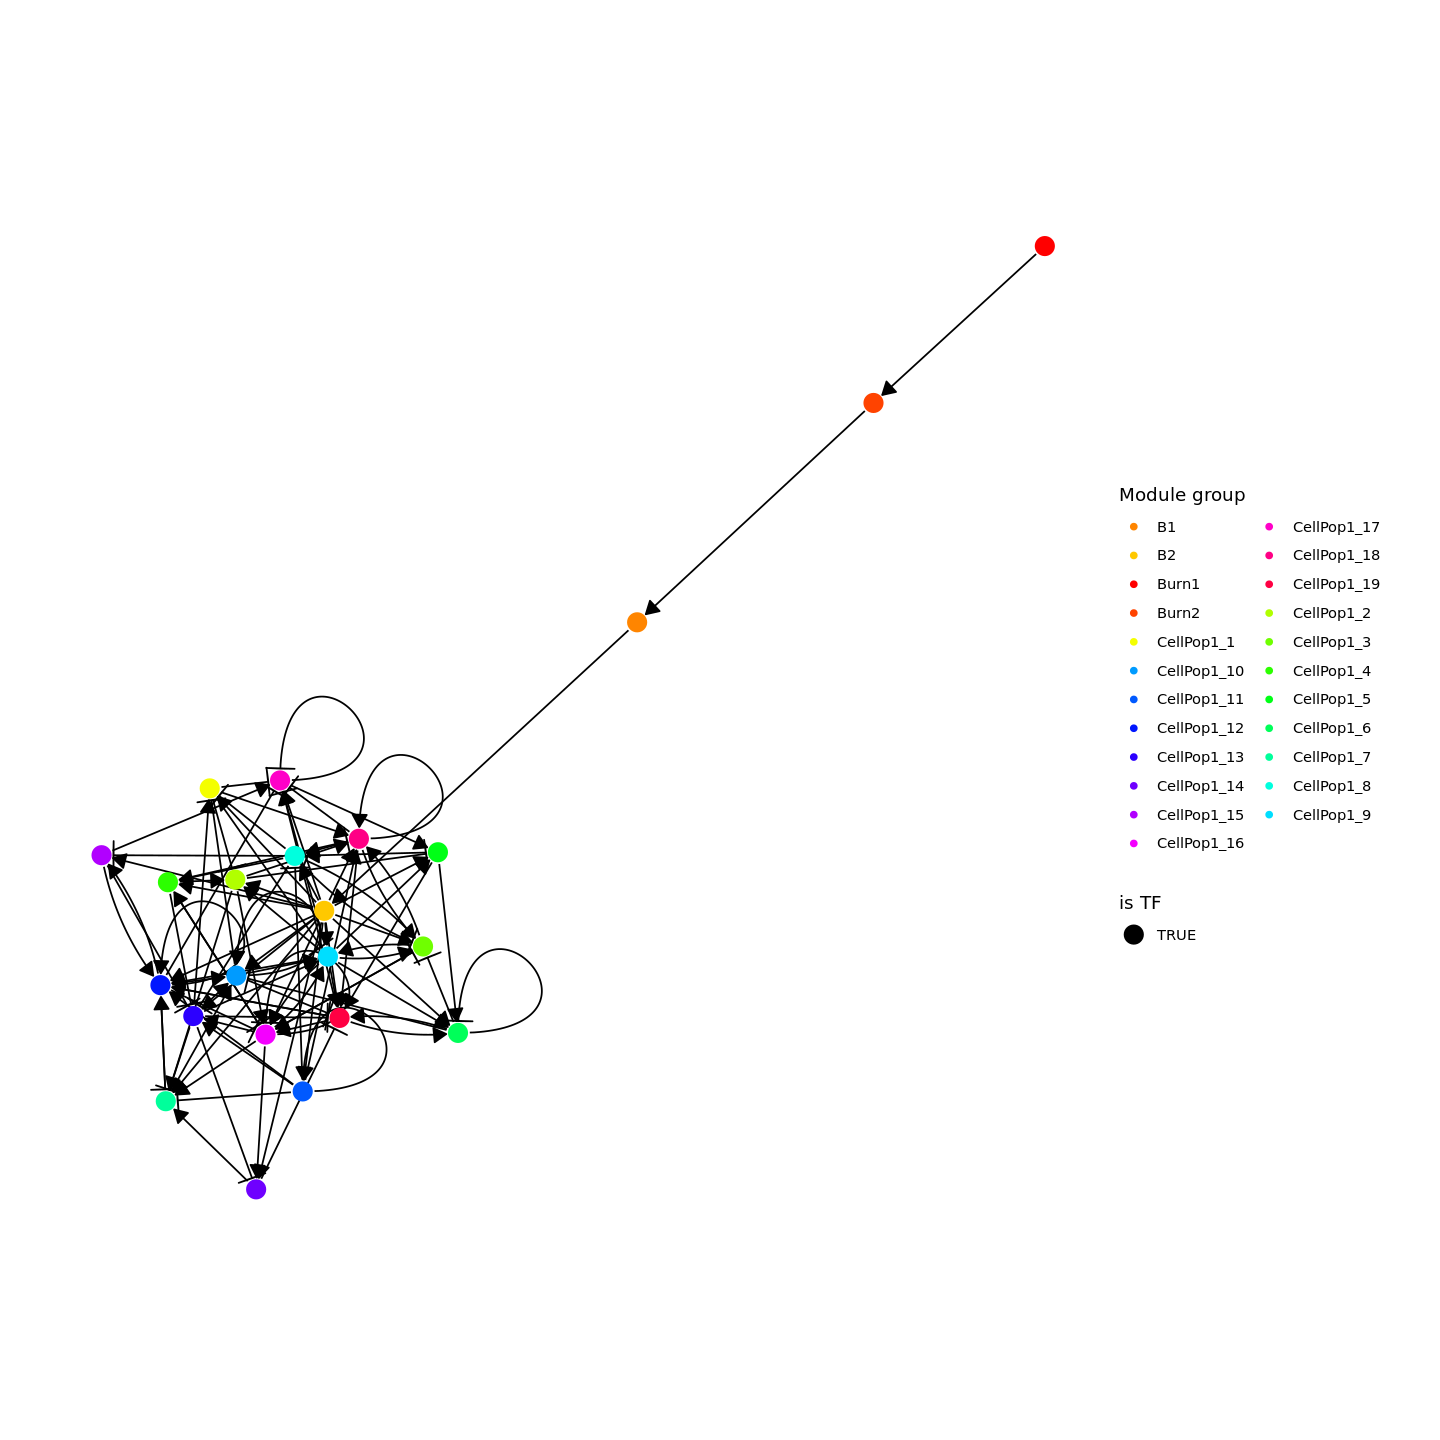

In [147]:
plot_feature_network(model_common, show_target=FALSE)

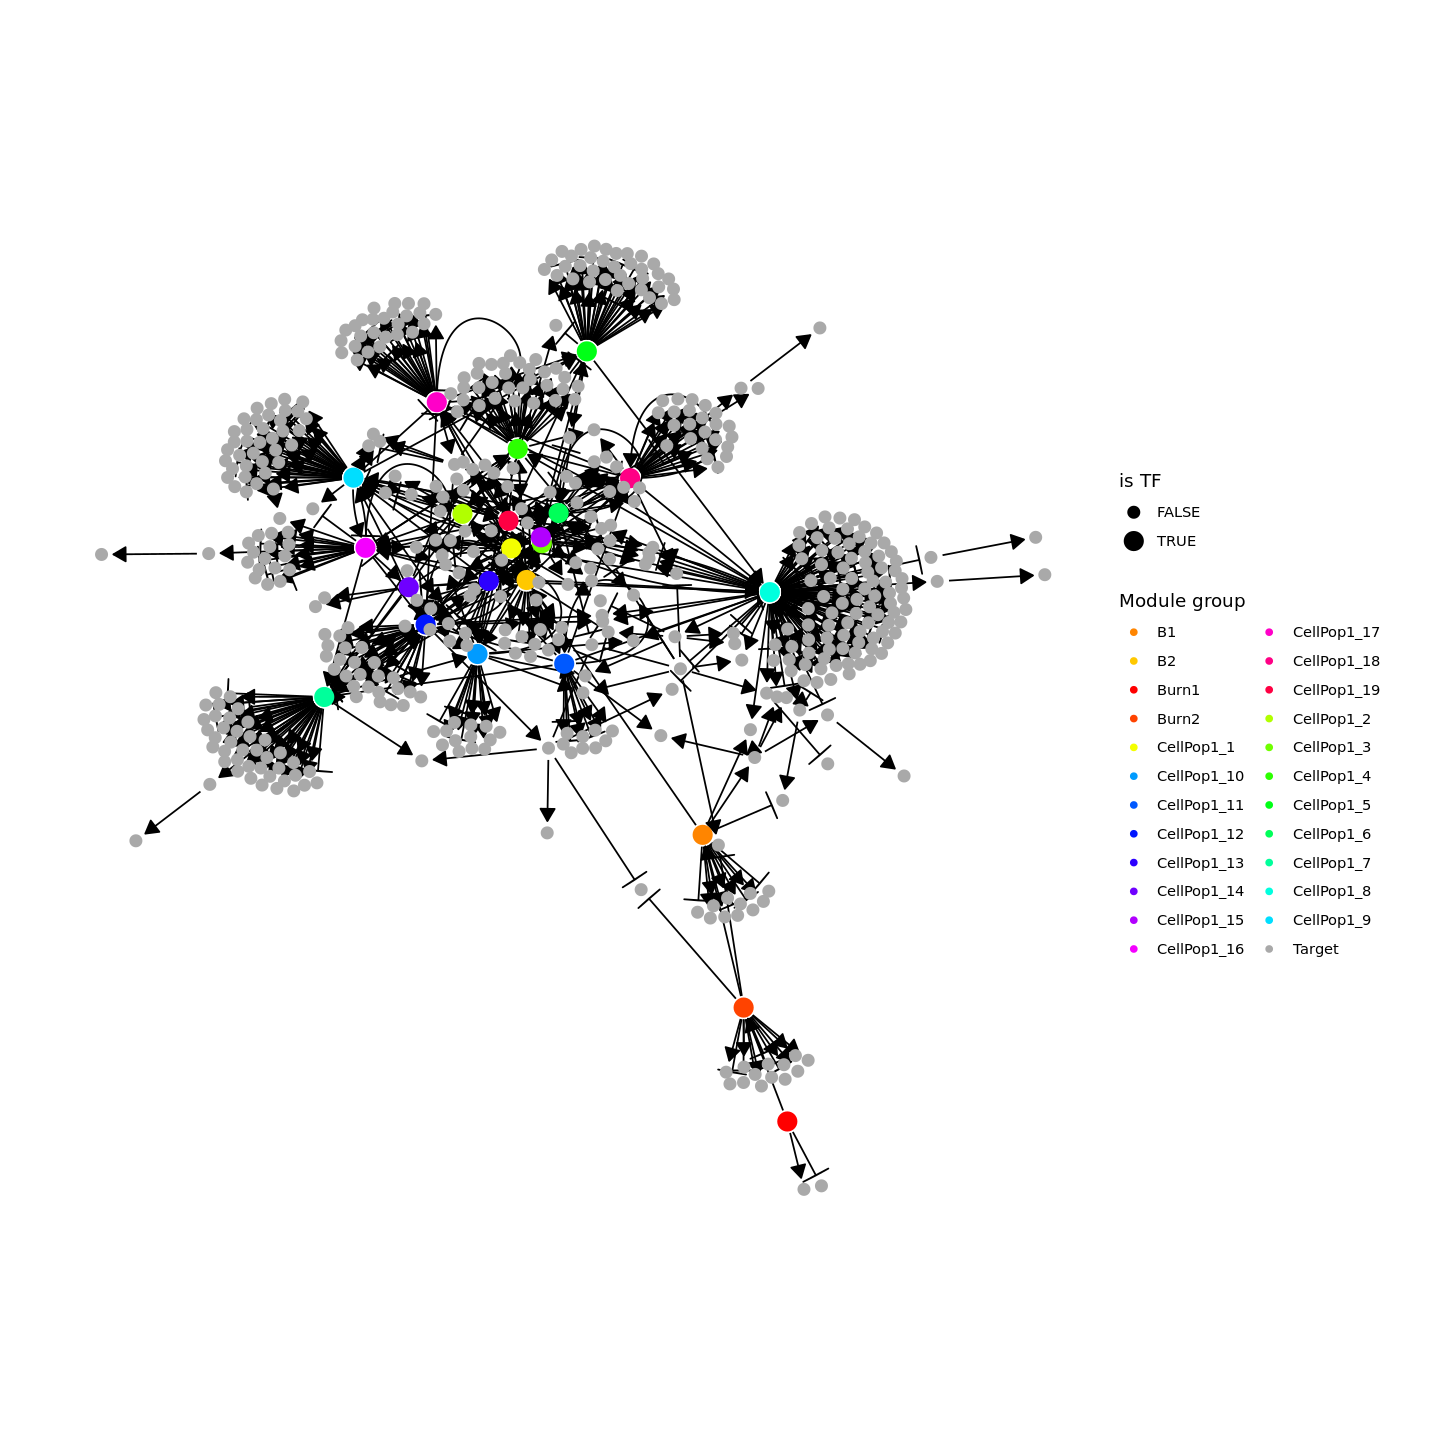

In [148]:
plot_feature_network(model_common)

## Testing Simulating KO Model

In [149]:
network_tfs = model_common$feature_info %>% filter(is_tf == TRUE & burn == FALSE) %>% pull(feature_id) %>% as.character
hk_and_effect_genes = model_common$feature_info %>% filter(is_tf == FALSE & burn == TRUE) %>% pull(feature_id) %>% as.character
all_non_burn_genes = c(network_tfs, hk_and_effect_genes)

In [150]:
perturb_expr = run_perturbation_experiment(model_common, network_tfs, slurm=TRUE)

Submitting job...
 jobid:13800675.



Warning message:
“Ignoring unknown parameters: stat”


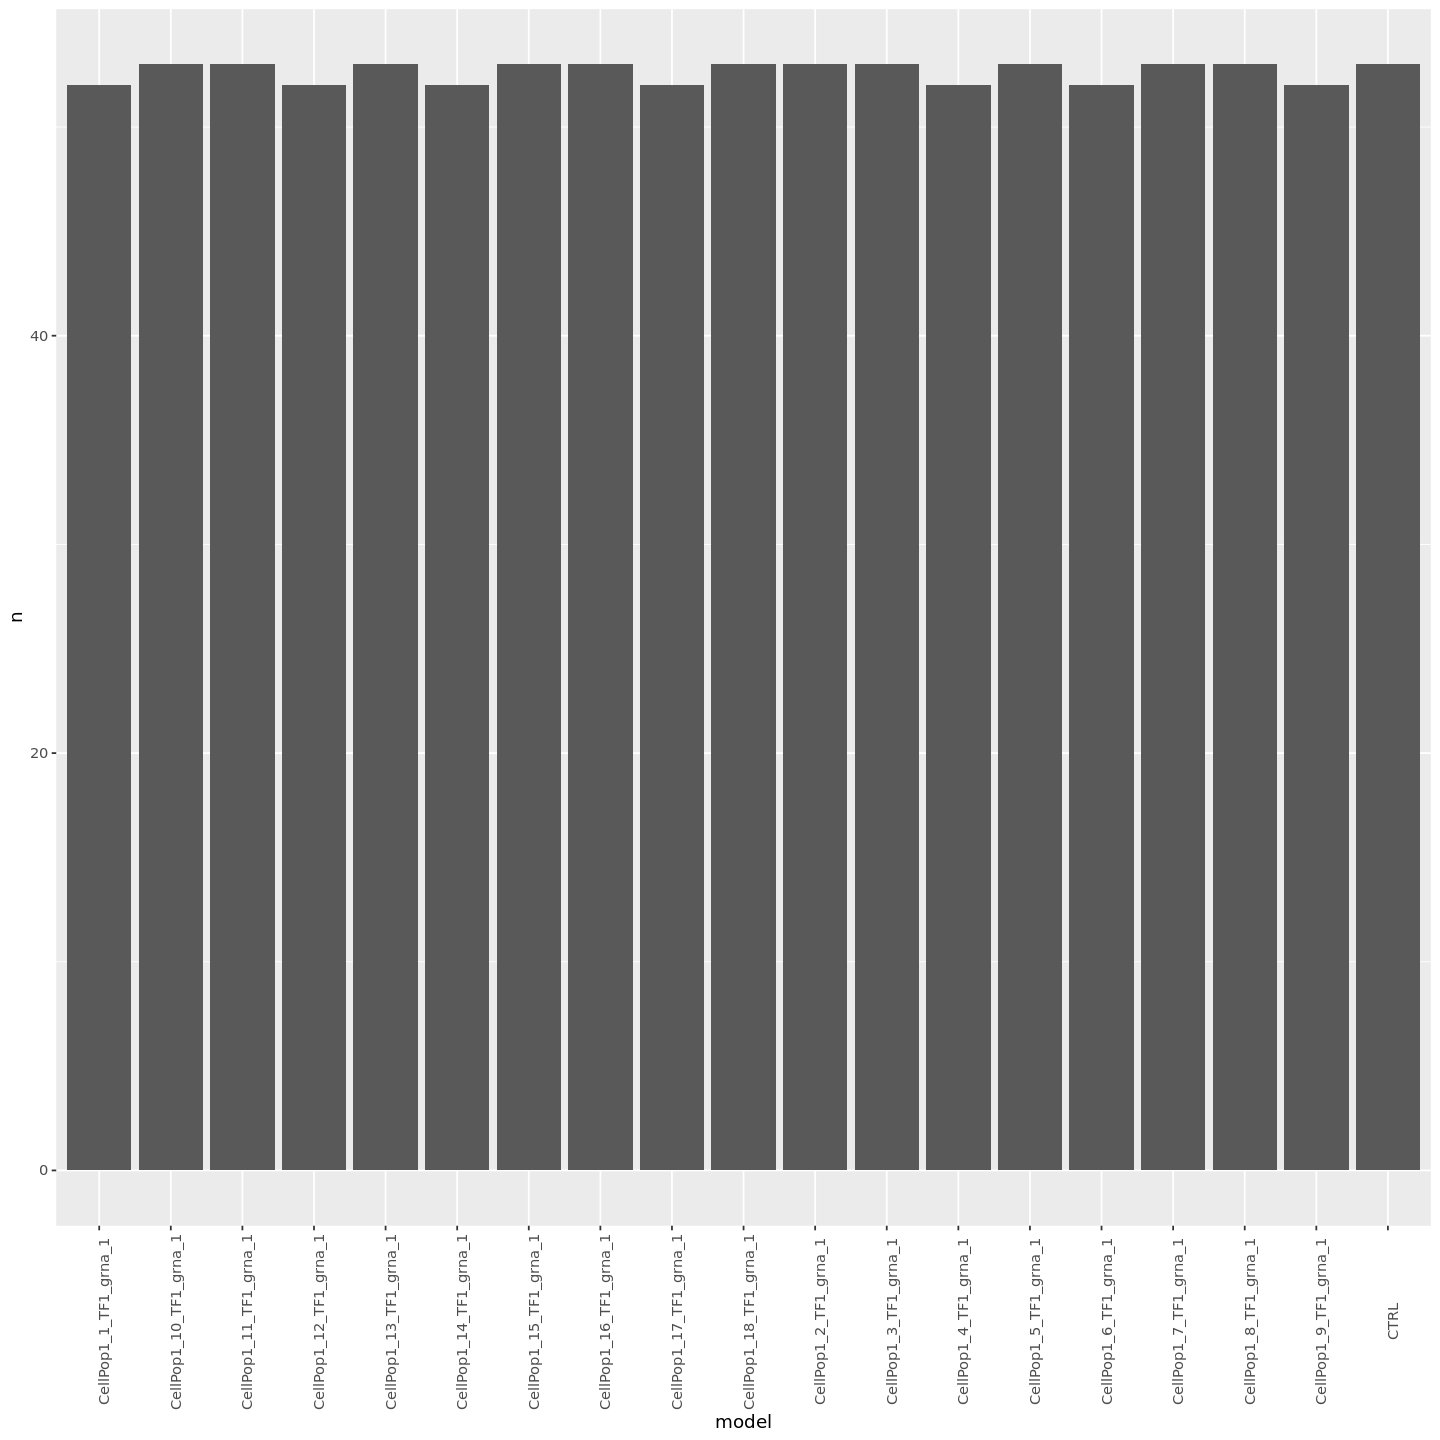

In [134]:
perturb_expr$experiment$cell_info %>% 
                            group_by(model) %>%
                            tally() %>%
                            ggplot(aes(x=model, y=n), fill=model) +
                            geom_col(stat='identity') + 
                            theme(axis.text.x = element_text(angle = 90)) 